# Predicting Airbnb Prices in Nashville, TN

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor, plot_importance, plot_tree

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('seaborn')

## Fetching and Cleaning Data

In [2]:
# features to read in to pandas DF
features = ['id',
            'last_scraped',
            'host_since',
            'host_response_time',
            'host_response_rate',
            'host_is_superhost',
            'host_total_listings_count',
            'host_has_profile_pic',
            'host_identity_verified',
            'latitude',
            'longitude',
            'property_type',
            'room_type',
            'accommodates',
            'bathrooms',
            'bedrooms',
            'beds',
            'bed_type',
            'price',
            'security_deposit',
            'cleaning_fee',
            'guests_included',
            'extra_people',
            'minimum_nights',
            'maximum_nights',
            'availability_30',
            'availability_60',
            'availability_90',
            'availability_365',
            'number_of_reviews',
            'number_of_reviews_ltm',
            'first_review',
            'last_review',
            'review_scores_rating',
            'review_scores_accuracy',
            'review_scores_cleanliness',
            'review_scores_checkin',
            'review_scores_communication',
            'review_scores_location',
            'review_scores_value',
            'instant_bookable',
            'is_business_travel_ready',
            'cancellation_policy',
            'require_guest_profile_picture',
            'require_guest_phone_verification',
            'reviews_per_month']

In [3]:
raw_data = pd.read_csv('data/listings.csv', true_values=['t'], false_values=['f'], usecols=features,
                 parse_dates=['last_scraped', 'host_since', 'first_review', 'last_review'])

In [4]:
def clean_data(raw_data):  
    """Clean entire dataset and prepare for modeling"""
    df = raw_data.copy()
    
    # Decrease dimensionality of property_type and bed_type features
    df.property_type = df.property_type.map(lambda x: x if x in ['House', 'Apartment', 'Condominium', 'Townhouse'] else 'Other')
    df.bed_type = df.bed_type.map(lambda x: x if x == 'Real Bed' else 'Other')
    
    # convert currencies to floats
    currency_cols = ['price', 'extra_people', 'security_deposit', 'cleaning_fee']
    for col in currency_cols:
        df[col] = df[col].astype(str)
        df[col] = df[col].map(lambda x: float(x.replace('$', '').replace(',', '')))
    
    # get distance from intersection of broadway and 1st ave (tourist location)
    bway_first = (36.162248, -86.774398)
    locs = pd.Series((zip(df.latitude, df.longitude)))
    df['dist_from_bway_miles'] = locs.map(lambda loc: geodesic(loc, bway_first).miles)
    
    # standardize availabilty features
    df.availability_30 = df.availability_30 / 30.
    df.availability_60 = df.availability_60 / 60.
    df.availability_90 = df.availability_90 / 90.
    df.availability_365 = df.availability_365 / 365.
    
    # convert rates and time differences to floats
    df['host_response_rate'] = df['host_response_rate'].str.replace('%', '.0').astype('float') / 100.0
    df['years_host_since'] = (df['last_scraped'] - df['host_since']) / np.timedelta64(1, 'Y')
    df['days_since_first_review'] = (df['last_scraped'] - df['first_review']) / np.timedelta64(1, 'D')
    df['days_since_last_review'] = (df['last_scraped'] - df['last_review']) / np.timedelta64(1, 'D')
    
    # convert True and False values to 1s and 0s
    df = df.replace(True, 1.).replace(False, 0.)
    
    # create dummy variables for categorical features 
    categorical_features = ['host_response_time',
                            'property_type',
                            'room_type',
                            'bed_type',
                            'cancellation_policy']
    df = pd.get_dummies(df, columns=categorical_features)
    
    # drop unnecessary columns and observations with NA values
    df.drop(['id', 'last_scraped', 'host_since', 'first_review', 'last_review'], axis=1, inplace=True)
    df = df.astype('float')
    df.dropna(inplace=True)
    
    # remove price outliers (keep middle 95%)
    quantiles = np.quantile(df.price, [0.025, 0.975])
    df = df.loc[(df.price > quantiles[0]) & (df.price < quantiles[1])]
    
    return df

In [5]:
df = clean_data(raw_data)
df.to_csv('data/clean_data.csv')

## Basic EDA

In [6]:
df.price.describe()

count    4958.000000
mean      224.998386
std       197.397135
min        46.000000
25%        99.000000
50%       152.000000
75%       259.750000
max      1000.000000
Name: price, dtype: float64

In [7]:
df.shape

(4958, 60)

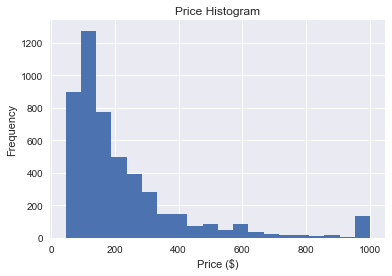

In [11]:
plt.hist(df.price, bins=20)
plt.title('Price Histogram')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.savefig('figures/price_hist.jpg', dpi=250)
plt.show()

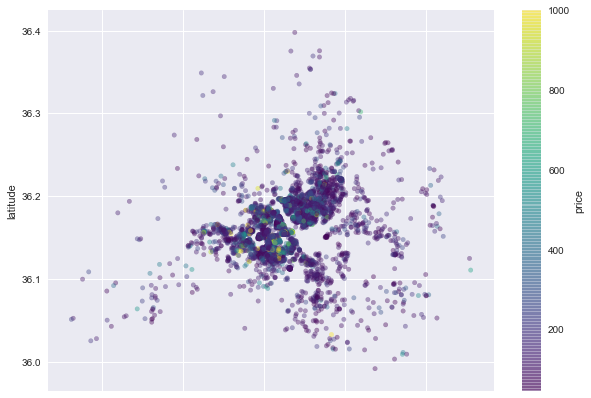

In [12]:
df.plot(kind="scatter", x="longitude", y="latitude",
    c="price", cmap=plt.get_cmap("viridis"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
plt.savefig('figures/price_map.jpg', dpi=250)
plt.show()

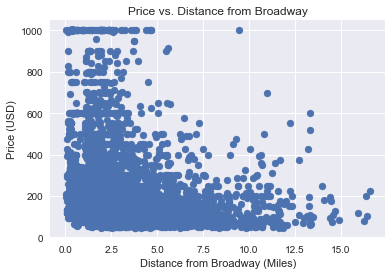

In [13]:
plt.scatter(df.dist_from_bway_miles, df.price)
plt.xlabel('Distance from Broadway (Miles)')
plt.ylabel('Price (USD)')
plt.title('Price vs. Distance from Broadway')
plt.savefig('figures/price_bway_dist.jpg', dpi=250)
plt.show()

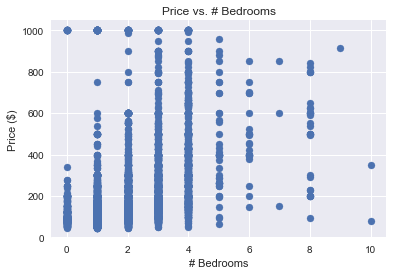

In [14]:
plt.scatter(df.bedrooms, df.price)
plt.xlabel('# Bedrooms')
plt.ylabel('Price ($)')
plt.title('Price vs. # Bedrooms')
plt.savefig('figures/price_BR.jpg', dpi=250)
plt.show()

##  Modeling

In [16]:
def evaluate(model, X_test, y_test):
    """function to evaluate an arbitrary model on the test set"""
    y_pred = model.predict(X_test)
    errors = abs(y_pred - y_test)
    sse = sum((y_pred - y_test)**2)
    mse = np.mean((y_pred - y_test)**2)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Test R^2: {:0.3f}'.format(model.score(X_test, y_test)))
    print('Mean Error: ${:0.2f}'.format(np.mean(errors)))
    print('Mean Absolute % Error: {:0.2f}%'.format(mape))
    print('SSE: {:0.2f}'.format(sse))
    print('MSE: {:0.2f}'.format(mse))
    print('RMSE: {:0.2f}'.format(np.sqrt(mse)))
    print('Accuracy = {:0.2f}%'.format(accuracy))

In [17]:
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### OLS

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)
evaluate(lr, X_test, y_test)

Test R^2: 0.536
Mean Error: $84.73
Mean Absolute % Error: 48.05%
SSE: 24393911.06
MSE: 16393.76
RMSE: 128.04
Accuracy = 51.95%


### Ridge

In [19]:
ridge_cv = RidgeCV(cv=20)
ridge_cv.fit(X_train, y_train)
evaluate(ridge_cv, X_test, y_test)

Test R^2: 0.537
Mean Error: $84.37
Mean Absolute % Error: 47.72%
SSE: 24361094.47
MSE: 16371.70
RMSE: 127.95
Accuracy = 52.28%


### Lasso

In [20]:
lasso_cv = LassoCV(cv=20, random_state=42)
lasso_cv.fit(X_train, y_train)
evaluate(lasso_cv, X_test, y_test)

Test R^2: 0.473
Mean Error: $89.57
Mean Absolute % Error: 50.75%
SSE: 27744478.63
MSE: 18645.48
RMSE: 136.55
Accuracy = 49.25%


### Random Forest

In [21]:
# Fit tuned model (GridCV not shown)
rf = RandomForestRegressor(bootstrap=True,
                           max_depth=50,
                           max_features='auto',
                           min_samples_leaf=3,
                           min_samples_split=4,
                           n_estimators=200)
rf.fit(X_train, y_train)
evaluate(rf, X_test, y_test)

kfold = KFold(n_splits=5, random_state=42)
results = cross_val_score(rf, X_train, y_train, cv=kfold)

print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Test R^2: 0.743
Mean Error: $59.67
Mean Absolute % Error: 32.63%
SSE: 13532129.66
MSE: 9094.17
RMSE: 95.36
Accuracy = 67.37%
Accuracy: 71.51% (4.14%)


In [22]:
# Get RF feature importances (by gain)
rf_feature_importances = pd.DataFrame([list(df.columns), rf.feature_importances_]).T
rf_feature_importances.sort_values(by=1, ascending=False).head(10)

,0,1
2,host_total_listings_count,0.335045
8,bathrooms,0.221074
35,reviews_per_month,0.0543794
7,accommodates,0.0478526
37,years_host_since,0.0414651
12,security_deposit,0.03847
34,require_guest_phone_verification,0.0291978
36,dist_from_bway_miles,0.022031
6,longitude,0.0175379
20,availability_90,0.0173943


### XGBoost

In [23]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb.fit(X_train, y_train)
evaluate(xgb, X_test, y_test)

Test R^2: 0.714
Mean Error: $64.52
Mean Absolute % Error: 34.52%
SSE: 15060649.25
MSE: 10121.40
RMSE: 100.61
Accuracy = 65.48%


#### Hyperparameter Tuning

In [24]:
params1 = {
    'max_depth':[4, 5, 6],
    'min_child_weight':[1, 2, 3,]
}
gs1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1,
                                             n_estimators=100,
                                             max_depth=6,
                                             min_child_weight=1,
                                             gamma=0,
                                             subsample=0.8,
                                             colsample_bytree=0.8,
                                             nthread=-1,
                                             scale_pos_weight=1,
                                             objective='reg:squarederror',
                                             seed=42),
                  param_grid=params1,
                  scoring='neg_mean_squared_error',
                  n_jobs=-1,
                  cv=3)

gs1.fit(X_train, y_train)
gs1.best_params_, gs1.best_score_

({'max_depth': 5, 'min_child_weight': 3}, -10359.520985863754)

In [25]:
params2 = {
    'gamma':[i/10. for i in range(0,1)],
}

gs2 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1,
                                             n_estimators=100,
                                             max_depth=5,
                                             min_child_weight=3,
                                             gamma=0,
                                             subsample=0.8,
                                             colsample_bytree=0.8,
                                             nthread=-1,
                                             scale_pos_weight=1,
                                             objective='reg:squarederror',
                                             seed=42),
                  param_grid=params2,
                  scoring='neg_mean_squared_error',
                  n_jobs=-1,
                  cv=3)

gs2.fit(X_train, y_train)
gs2.best_params_, gs2.best_score_

({'gamma': 0.0}, -10359.520985863754)

In [26]:
params3 = {
    'subsample':[i/10. for i in range(3,7)],
    'colsample_bytree':[i/10. for i in range(8,11)]
}

gs3 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1,
                                             n_estimators=100,
                                             max_depth=5,
                                             min_child_weight=3,
                                             gamma=0,
                                             subsample=0.8,
                                             colsample_bytree=0.8,
                                             nthread=-1,
                                             scale_pos_weight=1,
                                             objective='reg:squarederror',
                                             seed=42),
                  param_grid=params3,
                  scoring='neg_mean_squared_error',
                  n_jobs=-1,
                  cv=3)

gs3.fit(X_train, y_train)
gs3.best_params_, gs3.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.5}, -10606.216873459221)

In [27]:
params4 = {
    'reg_alpha':[10**i for i in [1, 2, 2.5, 3]],
    'reg_lambda':[10**i for i in [-10, -8, -6, -4, -2]]
}

gs4 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1,
                                             n_estimators=100,
                                             max_depth=5,
                                             min_child_weight=3,
                                             gamma=0,
                                             subsample=0.5,
                                             colsample_bytree=0.9,
                                             nthread=-1,
                                             scale_pos_weight=1,
                                             objective='reg:squarederror',
                                             seed=42),
                  param_grid=params4,
                  scoring='neg_mean_squared_error',
                  n_jobs=-1,
                  cv=3)

gs4.fit(X_train, y_train)
gs4.best_params_, gs4.best_score_

({'reg_alpha': 316.22776601683796, 'reg_lambda': 1e-10}, -10694.048367002517)

In [28]:
params5 = {
    'learning_rate':np.arange(0, 0.5, 0.05)
}

gs5 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1,
                                             n_estimators=100,
                                             max_depth=5,
                                             min_child_weight=3,
                                             gamma=0,
                                             subsample=0.5,
                                             colsample_bytree=0.9,
                                             reg_alpha=10**2.5,
                                             ref_lambda=1e-10,
                                             nthread=-1,
                                             scale_pos_weight=1,
                                             objective='reg:squarederror',
                                             seed=42),
                  param_grid=params5,
                  scoring='neg_mean_squared_error',
                  n_jobs=-1,
                  cv=3)

gs5.fit(X_train, y_train)
gs5.best_params_, gs5.best_score_

({'learning_rate': 0.1}, -10964.211291393196)

In [29]:
# Final model
xgb = XGBRegressor(learning_rate=0.1,
                   n_estimators=100,
                   max_depth=5,
                   min_child_weight=3,
                   gamma=0,
                   subsample=0.5,
                   colsample_bytree=0.9,
                   reg_alpha=10**2.5,
                   reg_lambda=1e-10,
                   nthread=-1,
                   scale_pos_weight=1,
                   objective='reg:squarederror',
                   seed=42)
xgb.fit(X_train, y_train)
evaluate(xgb, X_test, y_test)

Test R^2: 0.755
Mean Error: $58.20
Mean Absolute % Error: 30.85%
SSE: 12878265.88
MSE: 8654.75
RMSE: 93.03
Accuracy = 69.15%


#### Final Model Evaluation

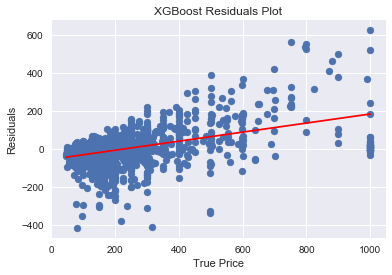

In [36]:
# residuals plot
y_pred = xgb.predict(X_test)
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, residuals, 1))(np.unique(y_test)), color='r')
plt.ylabel('Residuals')
plt.xlabel('True Price')
plt.title('XGBoost Residuals Plot')
plt.savefig('figures/xgb_residuals.jpg', dpi=250)
plt.show()

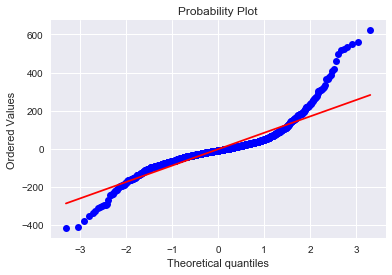

In [32]:
# Q-Q plot
fig, ax = plt.subplots()
sp.stats.probplot(residuals, plot=ax, fit=True)
plt.savefig('figures/xgb_qq.jpg', dpi=250)
plt.show()

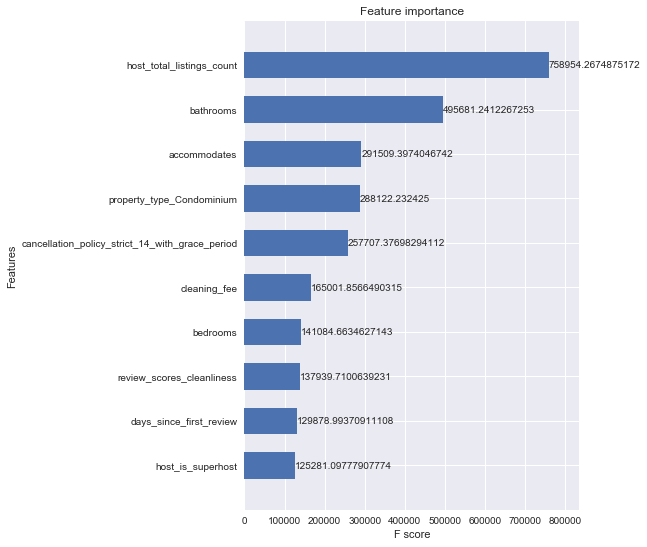

In [37]:
# plot 25-most importance features, where importance type is 'gain'
fig, ax = plt.subplots(figsize=(6,9))
plot_importance(xgb, max_num_features=10, height=0.6, ax=ax, importance_type='gain')
plt.savefig('figures/xgb_feat_imp.jpg', dpi=250)
plt.show()

In [38]:
# pearson correlation coef. of top 10 important features with price
features = xgb.get_booster().get_score(importance_type='gain')
top_10_features = sorted(features, key=features.get)[-10:][::-1]
df[top_10_features + ['price']].corr().loc['price']

host_total_listings_count                          0.498571
bathrooms                                          0.454495
accommodates                                       0.412065
property_type_Condominium                         -0.034357
cancellation_policy_strict_14_with_grace_period    0.269023
cleaning_fee                                       0.396606
bedrooms                                           0.382670
review_scores_cleanliness                          0.006321
days_since_first_review                           -0.087960
host_is_superhost                                 -0.099478
price                                              1.000000
Name: price, dtype: float64

In [39]:
# print gain values
gain = (sorted(xgb.get_booster().get_score(importance_type='gain').values()))[-10:][::-1]
list(zip(sorted(features, key=features.get)[-10:][::-1], gain))

[('host_total_listings_count', 758954.2674875172),
 ('bathrooms', 495681.2412267253),
 ('accommodates', 291509.3974046742),
 ('property_type_Condominium', 288122.232425),
 ('cancellation_policy_strict_14_with_grace_period', 257707.37698294112),
 ('cleaning_fee', 165001.8566490315),
 ('bedrooms', 141084.6634627143),
 ('review_scores_cleanliness', 137939.7100639231),
 ('days_since_first_review', 129878.99370911108),
 ('host_is_superhost', 125281.09777907774)]